# Predict pseudobulks

In [2]:
# import the VAE code
import sys
from buddi import buddi
from buddi.preprocessing import sc_preprocess
from buddi.plotting import validation_plotting as vp


# general imports

import warnings
import numpy as np
import scanpy as sc
import anndata as ad
import scipy


# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import scale, MinMaxScaler
from matplotlib_venn import venn2
from upsetplot import from_contents, UpSet

# programming stuff
import time
import os
import pickle
from pathlib import Path

# tensorflow stuff
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import to_categorical, normalize, plot_model


# disable eager execution
# https://github.com/tensorflow/tensorflow/issues/47311#issuecomment-786116401
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


2025-01-09 11:35:19.683207: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-09 11:35:19.683662: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-09 11:35:19.686116: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-09 11:35:19.692063: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736447719.701499 2619290 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736447719.70

In [3]:
## parameters
sc_aug_data_path = f"{os.getcwd()}/../../data/single_cell/GSE192898_pseudobulks/"
consensus_ov_gene_path = f"{os.getcwd()}/../../data/consensusOV_genes.csv"


exp_id = "all-cellType"

if exp_id == "all-cellType":
    res_id = "cellType" # cellType subtype celltype_granular
elif exp_id == "all-granular":
    res_id = "celltype_granular"
elif exp_id == "all-subtype":
    res_id = "subtype"


curr_treatment = "drug"

in_ad_file = f"{sc_aug_data_path}/{exp_id}.h5ad"

subtype_file = f"{sc_aug_data_path}/{exp_id}_subtypes.tsv"


In [4]:
adata = sc.read_h5ad(in_ad_file)

subtype_df = pd.read_csv(subtype_file, sep="\t")

if res_id == "subtype":
    adata.obs = adata.obs.rename({'IMR':'scIMR', 'DIF':'scDIF', 'PRO':'scPRO', 'MES':'scMES'}, axis=1)
    cell_types = ["scIMR", "scDIF", "scPRO", "scMES"]
elif res_id == "cellType":
    cell_types = ['B-cell',
                    'CD4+_T-cell',
                    'CD8+_T-cell',
                    'Endothelial_cell',
                    'Fibroblast',
                    'Macrophage',
                    'Monocyte',
                    'NK_cell',
                    'Tumor_cell']
else: # granular
    cell_types = ["immune", "stromal", "tumor"]



In [5]:
adata.obs

,sample_id,stim,isTraining,cell_prop_type,samp_type,CD8+_T-cell,Macrophage,CD4+_T-cell,Fibroblast,Tumor_cell,Monocyte,B-cell,NK_cell,Endothelial_cell
0,ovCHA004,CTRL,Train,random,sc_ref,0.230000,0.010000,0.025000,0.145000,0.025000,0.220000,0.005000,0.030000,0.310000
1,ovCHA004,CTRL,Train,random,sc_ref,0.130000,0.175000,0.030000,0.190000,0.070000,0.030000,0.115000,0.040000,0.220000
2,ovCHA004,CTRL,Train,random,sc_ref,0.165000,0.040000,0.025000,0.030000,0.255000,0.045000,0.010000,0.205000,0.225000
3,ovCHA004,CTRL,Train,random,sc_ref,0.425000,0.390000,0.015000,0.090000,0.005000,0.005000,0.020000,0.015000,0.035000
4,ovCHA004,CTRL,Train,random,sc_ref,0.115000,0.015000,0.125000,0.050000,0.065000,0.210000,0.125000,0.045000,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15195,ovCHA070,CTRL,Train,cell_type_specific,sc_ref,0.015784,0.002625,0.008655,0.013798,0.004773,0.001961,0.012416,0.010152,0.929837
15196,ovCHA070,CTRL,Train,cell_type_specific,sc_ref,0.002006,0.003758,0.015139,0.023089,0.006865,0.007913,0.011378,0.009467,0.920385
15197,ovCHA070,CTRL,Train,cell_type_specific,sc_ref,0.029388,0.029551,0.017759,0.049307,0.046459,0.004105,0.004123,0.034568,0.784740
15198,ovCHA070,CTRL,Train,cell_type_specific,sc_ref,0.008140,0.004736,0.006279,0.006490,0.003892,0.019156,0.043740,0.015757,0.891810


In [6]:
subtype_df

,IMR_consensus,DIF_consensus,PRO_consensus,MES_consensus,subtype
0,0.028,0.012,0.102,0.858,MES
1,0.042,0.072,0.168,0.718,MES
2,0.044,0.438,0.286,0.232,DIF
3,0.256,0.056,0.054,0.634,MES
4,0.096,0.216,0.104,0.584,MES
...,...,...,...,...,...
15195,0.020,0.084,0.654,0.242,PRO
15196,0.024,0.064,0.686,0.226,PRO
15197,0.010,0.034,0.800,0.156,PRO
15198,0.040,0.084,0.598,0.278,PRO


In [7]:
# append to obs they should be in exactly the same order
subtype_df.index = adata.obs.index
adata.obs = pd.concat([adata.obs, subtype_df], axis=1)

In [8]:

Y_full = adata.obs[cell_types]
Y_max = np.copy(Y_full)
Y_max = np.argmax(Y_max, axis=1)
Y_max = Y_full.columns[Y_max]
adata.obs["Y_max"] = Y_max

In [9]:
adata.obs

,sample_id,stim,isTraining,cell_prop_type,samp_type,CD8+_T-cell,Macrophage,CD4+_T-cell,Fibroblast,Tumor_cell,Monocyte,B-cell,NK_cell,Endothelial_cell,IMR_consensus,DIF_consensus,PRO_consensus,MES_consensus,subtype,Y_max
0,ovCHA004,CTRL,Train,random,sc_ref,0.230000,0.010000,0.025000,0.145000,0.025000,0.220000,0.005000,0.030000,0.310000,0.028,0.012,0.102,0.858,MES,Endothelial_cell
1,ovCHA004,CTRL,Train,random,sc_ref,0.130000,0.175000,0.030000,0.190000,0.070000,0.030000,0.115000,0.040000,0.220000,0.042,0.072,0.168,0.718,MES,Endothelial_cell
2,ovCHA004,CTRL,Train,random,sc_ref,0.165000,0.040000,0.025000,0.030000,0.255000,0.045000,0.010000,0.205000,0.225000,0.044,0.438,0.286,0.232,DIF,Tumor_cell
3,ovCHA004,CTRL,Train,random,sc_ref,0.425000,0.390000,0.015000,0.090000,0.005000,0.005000,0.020000,0.015000,0.035000,0.256,0.056,0.054,0.634,MES,CD8+_T-cell
4,ovCHA004,CTRL,Train,random,sc_ref,0.115000,0.015000,0.125000,0.050000,0.065000,0.210000,0.125000,0.045000,0.250000,0.096,0.216,0.104,0.584,MES,Endothelial_cell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15195,ovCHA070,CTRL,Train,cell_type_specific,sc_ref,0.015784,0.002625,0.008655,0.013798,0.004773,0.001961,0.012416,0.010152,0.929837,0.020,0.084,0.654,0.242,PRO,Endothelial_cell
15196,ovCHA070,CTRL,Train,cell_type_specific,sc_ref,0.002006,0.003758,0.015139,0.023089,0.006865,0.007913,0.011378,0.009467,0.920385,0.024,0.064,0.686,0.226,PRO,Endothelial_cell
15197,ovCHA070,CTRL,Train,cell_type_specific,sc_ref,0.029388,0.029551,0.017759,0.049307,0.046459,0.004105,0.004123,0.034568,0.784740,0.010,0.034,0.800,0.156,PRO,Endothelial_cell
15198,ovCHA070,CTRL,Train,cell_type_specific,sc_ref,0.008140,0.004736,0.006279,0.006490,0.003892,0.019156,0.043740,0.015757,0.891810,0.040,0.084,0.598,0.278,PRO,Endothelial_cell


# Plot

In [10]:
sc.tl.pca(adata, n_comps=50)


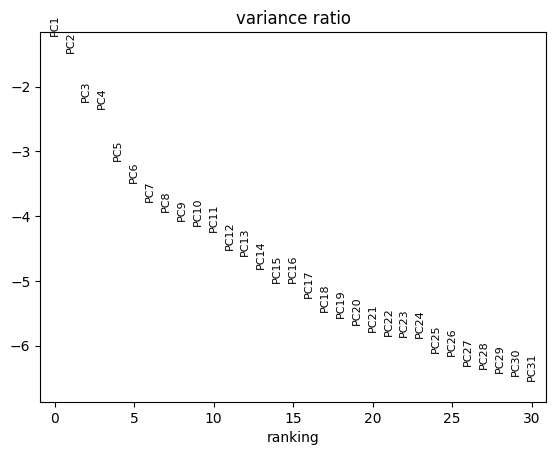

In [11]:
sc.pl.pca_variance_ratio(adata, log=True)


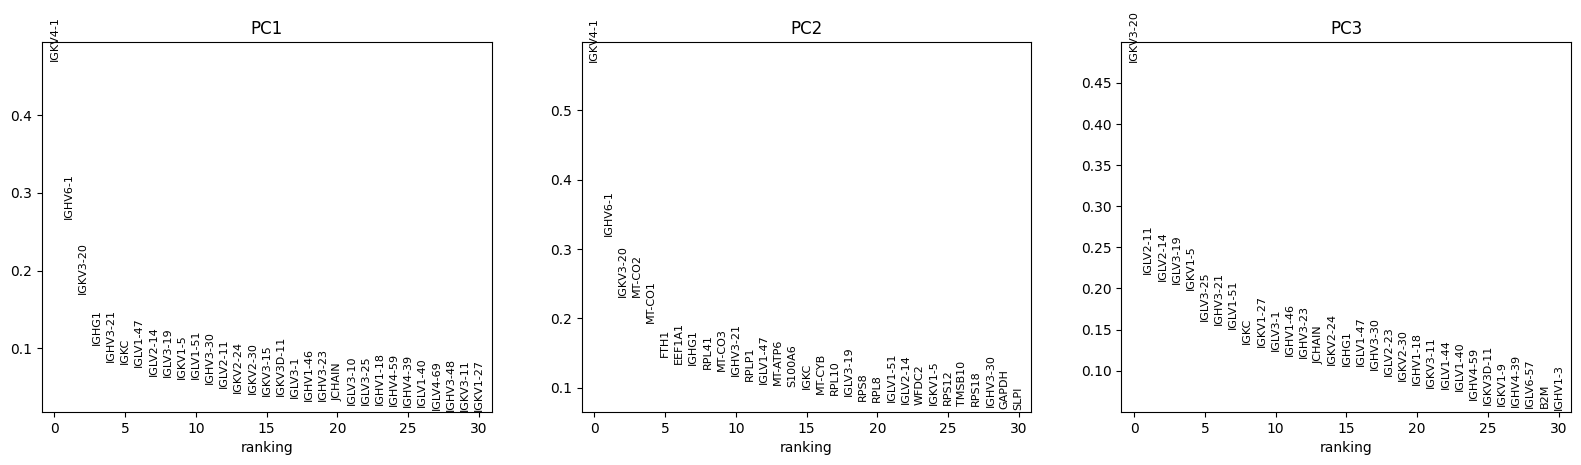

In [12]:
sc.pl.pca_loadings(adata, include_lowest=False)


In [13]:
# valculate neighborhood graph
sc.pp.neighbors(adata)

# make umap
sc.tl.umap(adata)


/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


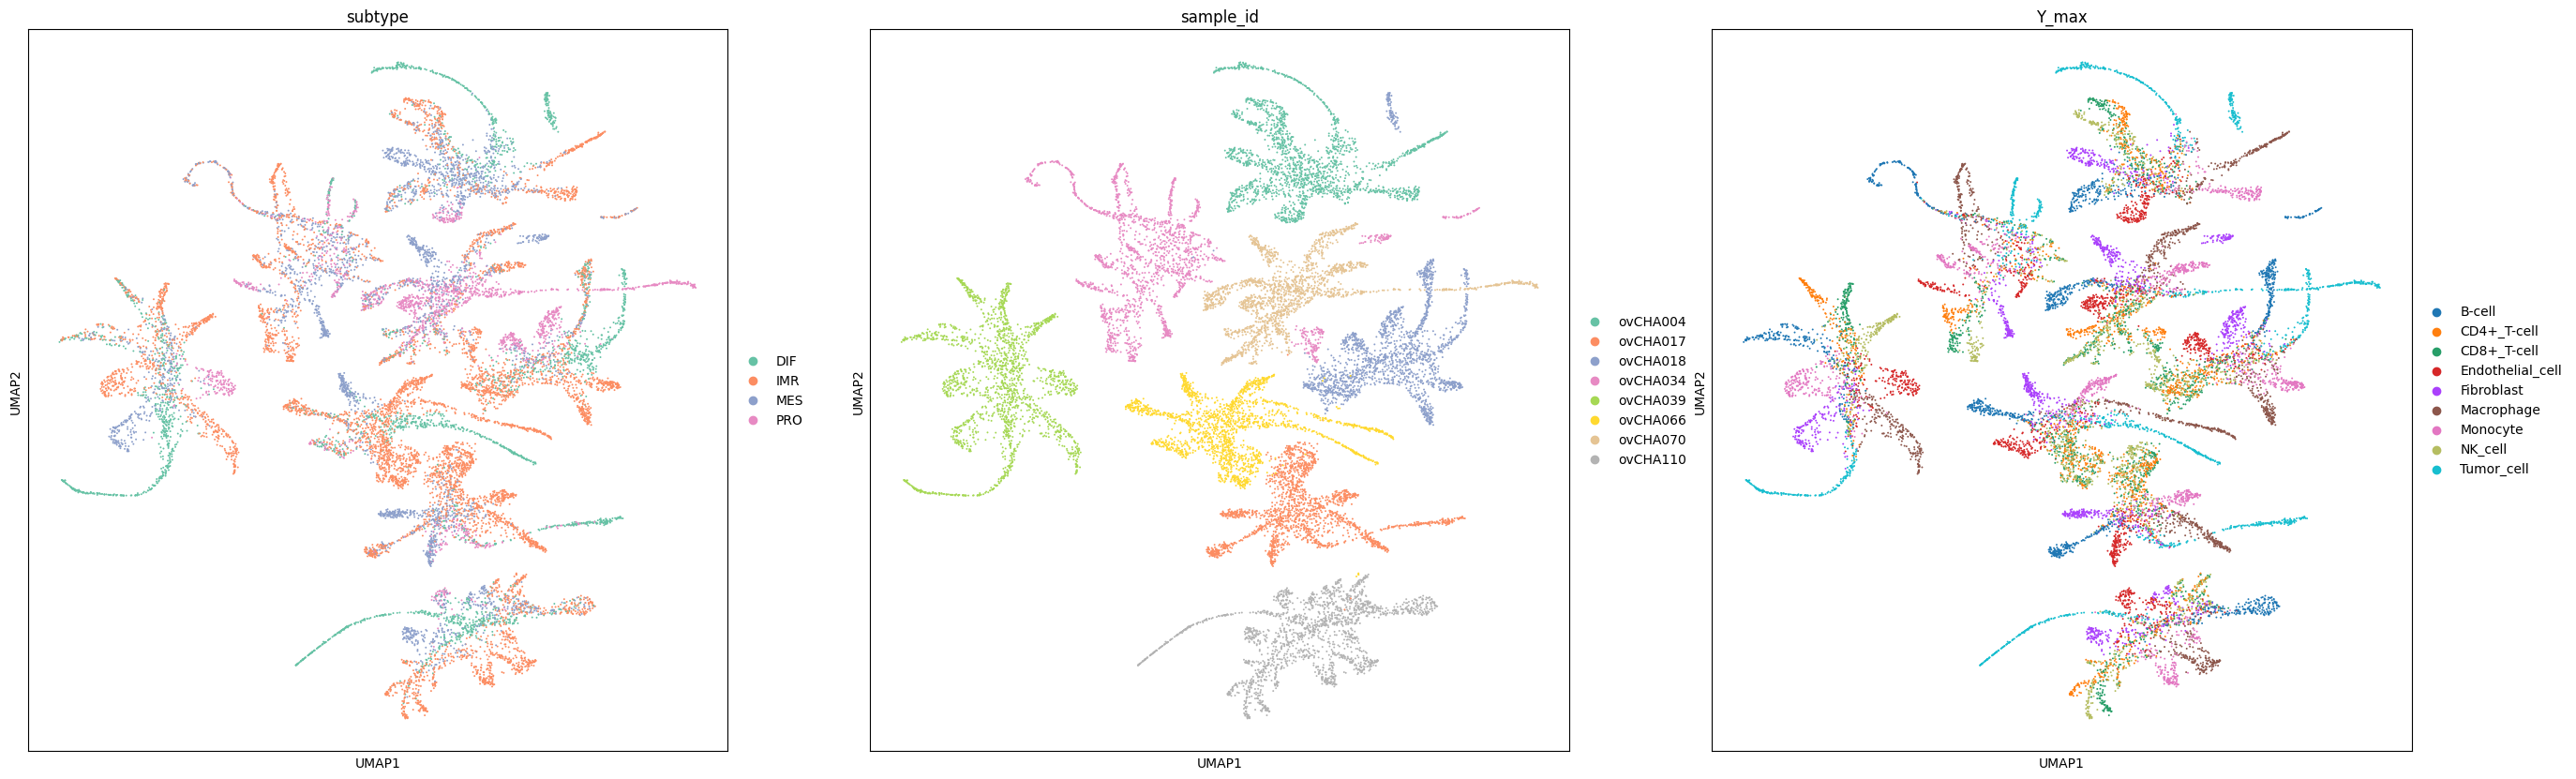

In [14]:
from matplotlib.pyplot import rc_context

# lets use previously identified clustering
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(adata, color=['subtype', 'sample_id', "Y_max"])


In [15]:
tab = adata.obs.groupby(['Y_max', 'subtype']).size()
tab.unstack()

subtype,DIF,IMR,MES,PRO
Y_max,,,,
B-cell,281,775,500,135
CD4+_T-cell,302,1035,284,101
CD8+_T-cell,235,1120,271,102
Endothelial_cell,247,139,509,795
Fibroblast,66,25,1373,213
Macrophage,93,1412,195,44
Monocyte,112,1278,216,49
NK_cell,221,1059,253,108
Tumor_cell,1231,15,26,380


In [16]:
tab = adata.obs.groupby(['sample_id', 'subtype']).size()
tab.unstack()

subtype,DIF,IMR,MES,PRO
sample_id,,,,
ovCHA004,358,642,812,88
ovCHA017,178,1092,484,146
ovCHA018,560,899,144,297
ovCHA034,80,843,709,268
ovCHA039,601,800,361,138
ovCHA066,405,1249,207,39
ovCHA070,81,426,500,893
ovCHA110,525,907,410,58


In [17]:
set(adata.obs.Y_max)

{'B-cell',
 'CD4+_T-cell',
 'CD8+_T-cell',
 'Endothelial_cell',
 'Fibroblast',
 'Macrophage',
 'Monocyte',
 'NK_cell',
 'Tumor_cell'}

In [18]:
tab = adata.obs.groupby(['sample_id', 'subtype']).size() # Epithelial cells
tab.unstack()

subtype,DIF,IMR,MES,PRO
sample_id,,,,
ovCHA004,358,642,812,88
ovCHA017,178,1092,484,146
ovCHA018,560,899,144,297
ovCHA034,80,843,709,268
ovCHA039,601,800,361,138
ovCHA066,405,1249,207,39
ovCHA070,81,426,500,893
ovCHA110,525,907,410,58


In [21]:
adata.obs.Y_max

0        Endothelial_cell
1        Endothelial_cell
2              Tumor_cell
3             CD8+_T-cell
4        Endothelial_cell
               ...       
15195    Endothelial_cell
15196    Endothelial_cell
15197    Endothelial_cell
15198    Endothelial_cell
15199    Endothelial_cell
Name: Y_max, Length: 15200, dtype: category
Categories (9, object): ['B-cell', 'CD4+_T-cell', 'CD8+_T-cell', 'Endothelial_cell', ..., 'Macrophage', 'Monocyte', 'NK_cell', 'Tumor_cell']

In [22]:
immune_ct = ["Tumor_cell"]

idx = np.where(np.logical_and(adata.obs.Y_max.isin(immune_ct), adata.obs.cell_prop_type == "cell_type_specific") )[0]

tab = adata.obs.iloc[idx].groupby(['sample_id', 'subtype']).size()
tab.unstack()

subtype,DIF,IMR,MES,PRO
sample_id,,,,
ovCHA004,100,0,0,0
ovCHA017,92,0,0,8
ovCHA018,100,0,0,0
ovCHA034,49,0,0,51
ovCHA039,100,0,0,0
ovCHA066,100,0,0,0
ovCHA070,0,0,0,100
ovCHA110,100,0,0,0


# set the label for Diff Exp

In [53]:
# set the label

cell_type_vec = np.array(["DIF_total"]*adata.obs.sample_id.shape[0])
pro_label_idx = np.where(adata.obs.sample_id.isin(["ovCHA070", "ovCHA034"]) )[0]
cell_type_vec[pro_label_idx] = "PRO_total"

adata.obs['subtype_total'] = cell_type_vec



In [55]:
tab = adata.obs.iloc[np.where(adata.obs.Y_max == "Fibroblast")[0]].groupby(['sample_id', 'subtype']).size()
tab.unstack()

subtype,DIF,IMR,MES,PRO
sample_id,,,,
ovCHA004,0,0,202,0
ovCHA017,0,0,196,13
ovCHA018,9,0,28,164
ovCHA034,0,0,217,0
ovCHA039,17,0,184,1
ovCHA066,21,25,166,1
ovCHA070,0,0,175,34
ovCHA110,19,0,205,0


In [56]:
immune_ct = ["Endothelial_cell"]

idx = np.where(np.logical_and(adata.obs.Y_max.isin(immune_ct), adata.obs.cell_prop_type == "cell_type_specific") )[0]

tab = adata.obs.iloc[idx].groupby(['sample_id', 'subtype']).size()
tab.unstack()

subtype,DIF,IMR,MES,PRO
sample_id,,,,
ovCHA004,1,0,28,71
ovCHA017,1,1,78,20
ovCHA018,4,0,6,90
ovCHA034,1,0,24,75
ovCHA039,1,0,4,95
ovCHA066,38,35,0,27
ovCHA070,0,0,3,97
ovCHA110,29,0,28,43


In [57]:
immune_ct = ["CD4+_T-cell"]

idx = np.where(np.logical_and(adata.obs.Y_max.isin(immune_ct), adata.obs.cell_prop_type == "cell_type_specific") )[0]

tab = adata.obs.iloc[idx].groupby(['sample_id', 'subtype']).size()
tab.unstack()

subtype,DIF,IMR,MES,PRO
sample_id,,,,
ovCHA004,12,71,17,0
ovCHA017,0,98,2,0
ovCHA018,14,85,1,0
ovCHA034,1,84,13,2
ovCHA039,49,37,14,0
ovCHA066,0,100,0,0
ovCHA070,23,23,29,25
ovCHA110,11,88,1,0


In [59]:
immune_ct = ["Macrophage"]

idx = np.where(np.logical_and(adata.obs.Y_max.isin(immune_ct), adata.obs.cell_prop_type == "cell_type_specific") )[0]

tab = adata.obs.iloc[idx].groupby(['sample_id', 'subtype']).size()
tab.unstack()

subtype,DIF,IMR,MES,PRO
sample_id,,,,
ovCHA004,0,91,9,0
ovCHA017,0,100,0,0
ovCHA018,3,97,0,0
ovCHA034,0,95,5,0
ovCHA039,0,100,0,0
ovCHA066,0,100,0,0
ovCHA070,1,76,18,5
ovCHA110,0,100,0,0


# Differential Expression

In [60]:
# normalize to 10K counts per cell
sc.pp.normalize_total(adata, target_sum=1e6)

# log data
sc.pp.log1p(adata)

# get high variance genes
#sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# now process the counts further for doing  
# analysis and the cell clustering
#adata = adata[:, adata.var.highly_variable]

# scale the genes
sc.pp.scale(adata, max_value=10)

# calculate PCA
sc.tl.pca(adata, n_comps=20)

# valculate neighborhood graph
sc.pp.neighbors(adata)

# make umap
sc.tl.umap(adata)

/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


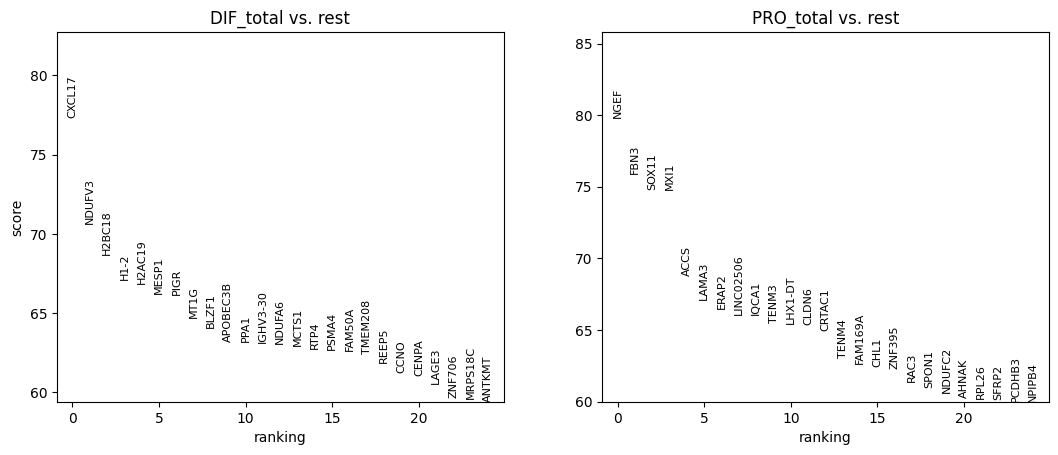

In [61]:
sc.tl.rank_genes_groups(adata, 'subtype_total', method='wilcoxon', key_added = "wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key="wilcoxon")

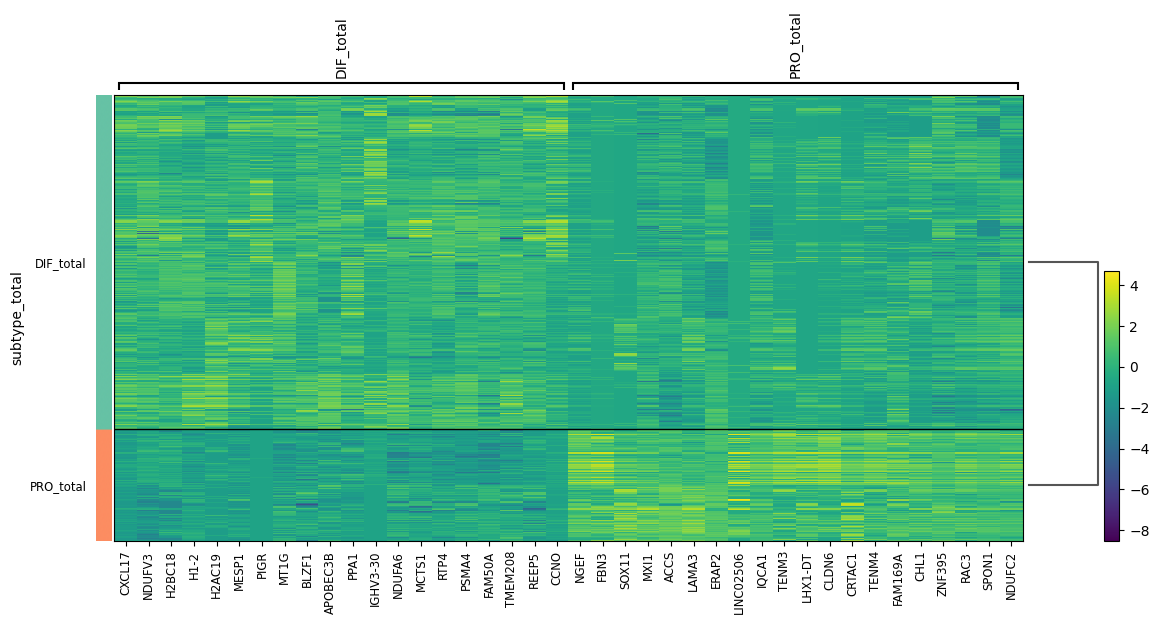

In [62]:
sc.pl.rank_genes_groups_heatmap(adata, n_genes=20, key="wilcoxon", groupby="subtype_total", show_gene_labels=True)


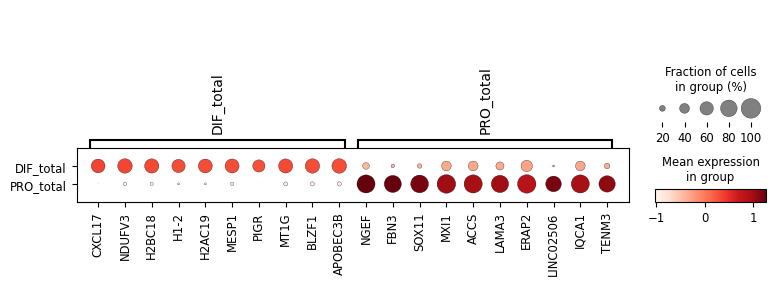

In [63]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=10, key="wilcoxon", groupby="subtype_total")


/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


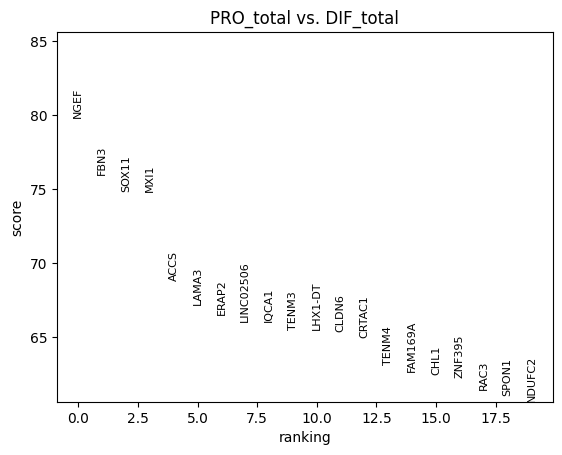

/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/scanpy/plotting/_tools/__init__.py:1314: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


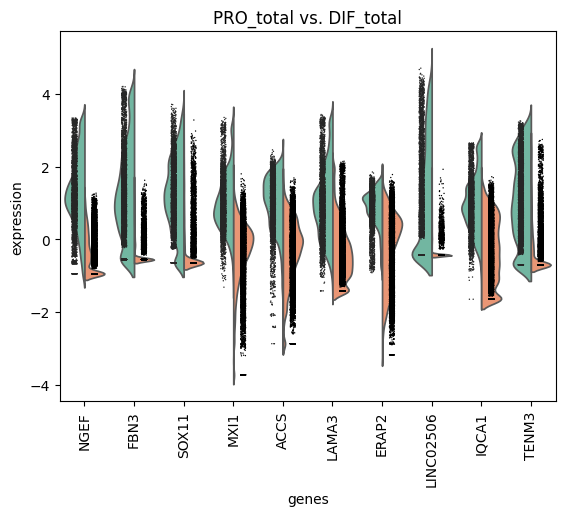

In [64]:
sc.tl.rank_genes_groups(adata, 'subtype_total', groups=['PRO_total'], reference='DIF_total', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['PRO_total'], n_genes=20)
sc.pl.rank_genes_groups_violin(adata, groups='PRO_total', n_genes=10)


In [65]:
wc = adata.uns['wilcoxon']['names']["PRO_total"]
wc[0:100]

array(['NGEF', 'FBN3', 'SOX11', 'MXI1', 'ACCS', 'LAMA3', 'ERAP2',
       'LINC02506', 'IQCA1', 'TENM3', 'LHX1-DT', 'CLDN6', 'CRTAC1',
       'TENM4', 'FAM169A', 'CHL1', 'ZNF395', 'RAC3', 'SPON1', 'NDUFC2',
       'AHNAK', 'RPL26', 'SFRP2', 'PCDHB3', 'NPIPB4', 'PGAM2', 'BORCS7',
       'MFAP2', 'CIC', 'DRD4', 'IQCN', 'SLC2A1', 'ATP2B1', 'IMPG2',
       'ST6GAL2', 'SNORC', 'CATSPER2', 'IGF2', 'GRP', 'LRRN2', 'PCED1A',
       'ARL2', 'CECR2', 'ACAA2', 'CXCL14', 'SGSH', 'DPT', 'GAB2', 'RPS3A',
       'EYA4', 'SLC2A1-AS1', 'TUBB2B', 'ZRANB1', 'CAPRIN2', 'IL11RA',
       'LHX1', 'PNMA3', 'FGF18', 'LAMA1', 'CROCC', 'TNNT1', 'AC005537.1',
       'VSIG2', 'WASHC1', 'SYNJ2BP-COX16', 'DNM1', 'TBC1D16', 'MAP4K2',
       'CDH2', 'BRAT1', 'FGFR1', 'C1QTNF3', 'DPP10', 'EMX2', 'HFM1',
       'KCNQ1OT1', 'RPL37A', 'CDH23', 'REPS1', 'CA4', 'CIB2', 'ERLIN2',
       'FXYD7', 'ADARB2', 'KIAA0100', 'PCDHGA7', 'LRRIQ1', 'ANGPTL1',
       'RTCA-AS1', 'PRAME', 'CCDC191', 'IDH3B', 'AC008014.1', 'GCC1',
       '

# Plot results

In [66]:
immune_ct = ["Samp_T76"]
idx = np.where(~adata.obs.sample_id.isin(immune_ct) )[0]
adata = adata[idx]


In [67]:
# get consensusOV genes
consensus_genes = pd.read_csv(consensus_ov_gene_path)
consensus_genes = np.intersect1d(consensus_genes.gene, adata.var.gene_ids)

adata = adata[:, consensus_genes]


consensus_genes

array(['ADAMDEC1', 'ANXA1', 'APOBEC3G', 'BLMH', 'CACNA1C', 'CALD1',
       'CASP1', 'CLU', 'COL4A6', 'COL5A1', 'COL8A1', 'COPS3', 'CXCL10',
       'DDR2', 'DLC1', 'DLEC1', 'EFS', 'EVI2A', 'F2R', 'FCER1G', 'FN1',
       'FSCN1', 'FUT2', 'GAS7', 'GIMAP5', 'IL21R', 'KIF1A', 'KMO', 'LAG3',
       'LAMB1', 'LAPTM5', 'LCN2', 'LGALS1', 'MAPRE1', 'MAPRE2', 'MARCKS',
       'MARCKSL1', 'MFAP2', 'MGLL', 'MLPH', 'MMP14', 'NBL1', 'NETO2',
       'NNMT', 'NUAK1', 'PALLD', 'PCOLCE', 'PDPN', 'PDZK1IP1', 'PKIA',
       'PTGER2', 'RHOBTB3', 'RIN1', 'RUNX1', 'SALL2', 'SCGB2A2', 'SLA',
       'SLC31A2', 'SLC37A1', 'SMARCD1', 'SSH3', 'STEAP3', 'STMN1',
       'TCF7L1', 'TNFRSF14', 'TPST1', 'UBE2L6', 'WIPF1'], dtype=object)

In [68]:
adata

View of AnnData object with n_obs × n_vars = 15200 × 68
    obs: 'sample_id', 'stim', 'isTraining', 'cell_prop_type', 'samp_type', 'CD8+_T-cell', 'Macrophage', 'CD4+_T-cell', 'Fibroblast', 'Tumor_cell', 'Monocyte', 'B-cell', 'NK_cell', 'Endothelial_cell', 'IMR_consensus', 'DIF_consensus', 'PRO_consensus', 'MES_consensus', 'subtype', 'Y_max', 'subtype_total'
    var: 'gene_ids', 'mean', 'std'
    uns: 'pca', 'neighbors', 'umap', 'subtype_colors', 'sample_id_colors', 'Y_max_colors', 'log1p', 'wilcoxon', 'subtype_total_colors', 'dendrogram_subtype_total', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [69]:
adata.obs

,sample_id,stim,isTraining,cell_prop_type,samp_type,CD8+_T-cell,Macrophage,CD4+_T-cell,Fibroblast,Tumor_cell,...,B-cell,NK_cell,Endothelial_cell,IMR_consensus,DIF_consensus,PRO_consensus,MES_consensus,subtype,Y_max,subtype_total
0,ovCHA004,CTRL,Train,random,sc_ref,0.230000,0.010000,0.025000,0.145000,0.025000,...,0.005000,0.030000,0.310000,0.028,0.012,0.102,0.858,MES,Endothelial_cell,DIF_total
1,ovCHA004,CTRL,Train,random,sc_ref,0.130000,0.175000,0.030000,0.190000,0.070000,...,0.115000,0.040000,0.220000,0.042,0.072,0.168,0.718,MES,Endothelial_cell,DIF_total
2,ovCHA004,CTRL,Train,random,sc_ref,0.165000,0.040000,0.025000,0.030000,0.255000,...,0.010000,0.205000,0.225000,0.044,0.438,0.286,0.232,DIF,Tumor_cell,DIF_total
3,ovCHA004,CTRL,Train,random,sc_ref,0.425000,0.390000,0.015000,0.090000,0.005000,...,0.020000,0.015000,0.035000,0.256,0.056,0.054,0.634,MES,CD8+_T-cell,DIF_total
4,ovCHA004,CTRL,Train,random,sc_ref,0.115000,0.015000,0.125000,0.050000,0.065000,...,0.125000,0.045000,0.250000,0.096,0.216,0.104,0.584,MES,Endothelial_cell,DIF_total
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15195,ovCHA070,CTRL,Train,cell_type_specific,sc_ref,0.015784,0.002625,0.008655,0.013798,0.004773,...,0.012416,0.010152,0.929837,0.020,0.084,0.654,0.242,PRO,Endothelial_cell,PRO_total
15196,ovCHA070,CTRL,Train,cell_type_specific,sc_ref,0.002006,0.003758,0.015139,0.023089,0.006865,...,0.011378,0.009467,0.920385,0.024,0.064,0.686,0.226,PRO,Endothelial_cell,PRO_total
15197,ovCHA070,CTRL,Train,cell_type_specific,sc_ref,0.029388,0.029551,0.017759,0.049307,0.046459,...,0.004123,0.034568,0.784740,0.010,0.034,0.800,0.156,PRO,Endothelial_cell,PRO_total
15198,ovCHA070,CTRL,Train,cell_type_specific,sc_ref,0.008140,0.004736,0.006279,0.006490,0.003892,...,0.043740,0.015757,0.891810,0.040,0.084,0.598,0.278,PRO,Endothelial_cell,PRO_total


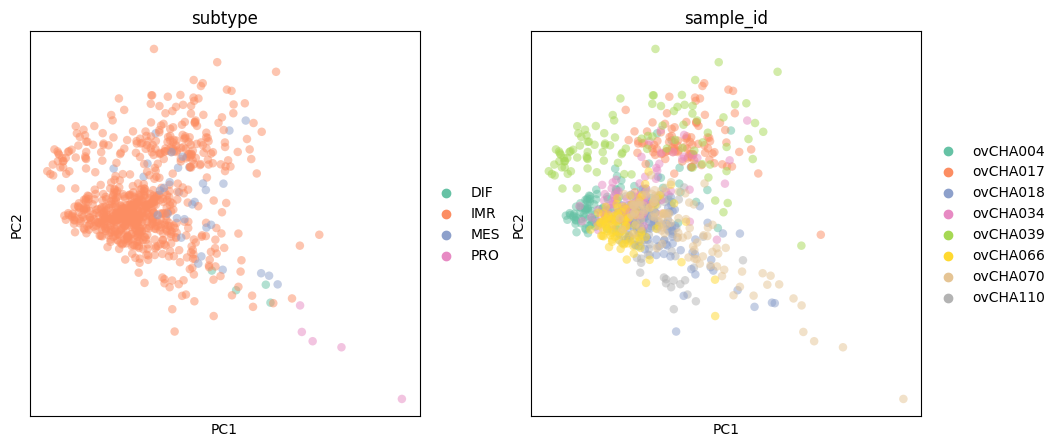

In [71]:
immune_ct = ["Macrophage"]

idx = np.where(np.logical_and(adata.obs.Y_max.isin(immune_ct), adata.obs.cell_prop_type == "cell_type_specific") )[0]



with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.pca(adata[idx], color=['subtype', 'sample_id'], alpha=0.5)

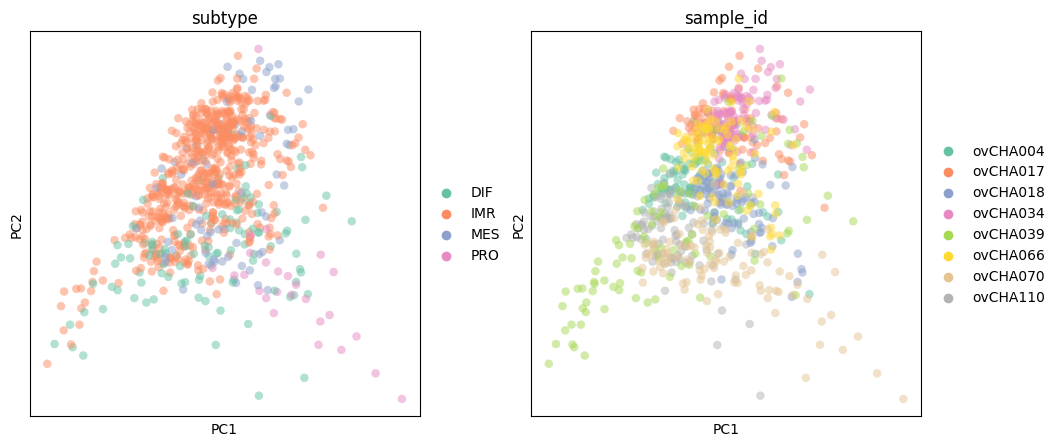

In [74]:
immune_ct = ["CD4+_T-cell"]

idx = np.where(np.logical_and(adata.obs.Y_max.isin(immune_ct), adata.obs.cell_prop_type == "cell_type_specific") )[0]



with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.pca(adata[idx], color=['subtype', 'sample_id'], alpha=0.5)

/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


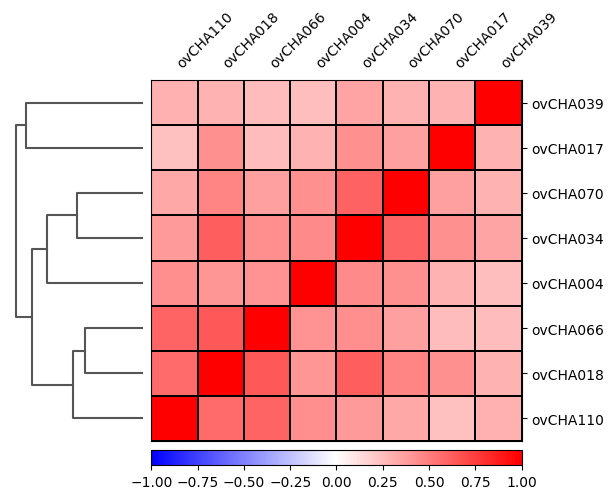

In [76]:
immune_ct = ["Tumor_cell"]
subtype_ct = ["DIF", "PRO"]

idx = np.logical_and(adata.obs.Y_max.isin(immune_ct), adata.obs.cell_prop_type == "cell_type_specific") 
idx = np.where(np.logical_and(idx, adata.obs.subtype.isin(subtype_ct)) )[0]

sc.pl.correlation_matrix(adata[idx], groupby="sample_id")

In [77]:
adata.obs.columns

Index(['sample_id', 'stim', 'isTraining', 'cell_prop_type', 'samp_type',
       'CD8+_T-cell', 'Macrophage', 'CD4+_T-cell', 'Fibroblast', 'Tumor_cell',
       'Monocyte', 'B-cell', 'NK_cell', 'Endothelial_cell', 'IMR_consensus',
       'DIF_consensus', 'PRO_consensus', 'MES_consensus', 'subtype', 'Y_max',
       'subtype_total'],
      dtype='object')

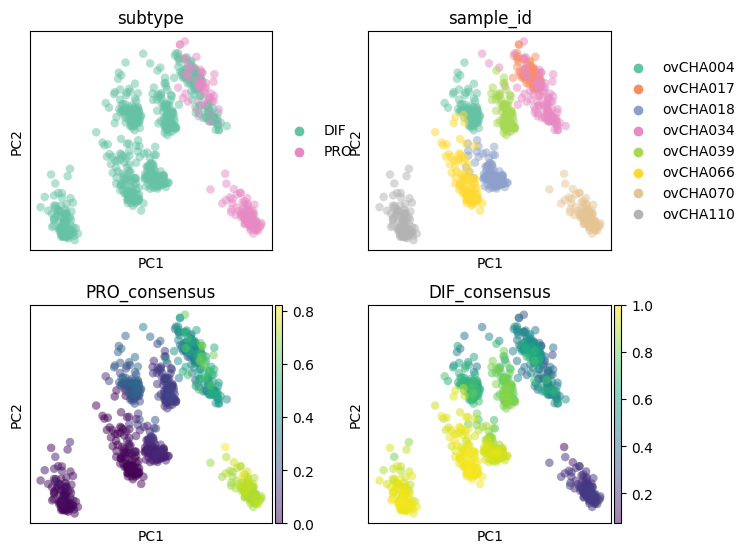

In [79]:
immune_ct = ["Tumor_cell"]

idx = np.where(np.logical_and(adata.obs.Y_max.isin(immune_ct), adata.obs.cell_prop_type == "cell_type_specific") )[0]



with rc_context({'figure.figsize': (3, 3)}):
    sc.pl.pca(adata[idx], color=['subtype', 'sample_id', "PRO_consensus", "DIF_consensus"], ncols=2, alpha=0.5)

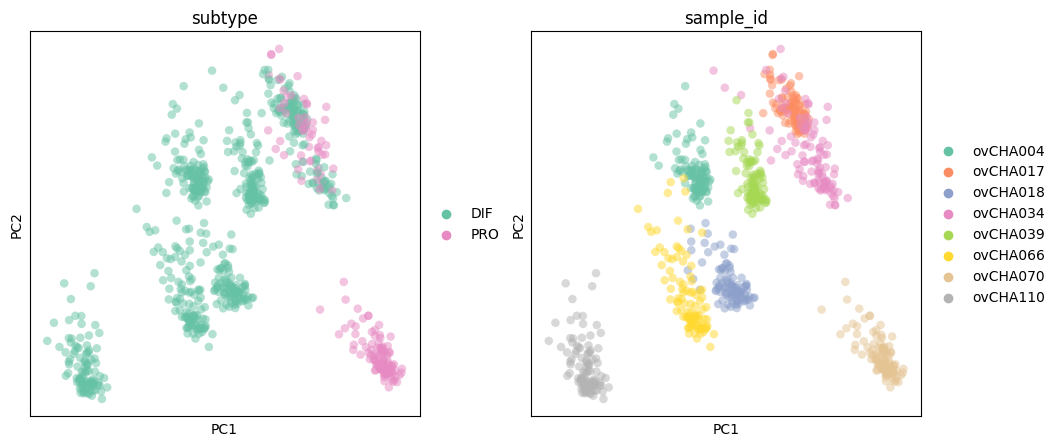

In [80]:
immune_ct = ["Tumor_cell"]

idx = np.where(np.logical_and(adata.obs.Y_max.isin(immune_ct), adata.obs.cell_prop_type == "cell_type_specific") )[0]


with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.pca(adata[idx], color=['subtype', 'sample_id'], alpha=0.5)

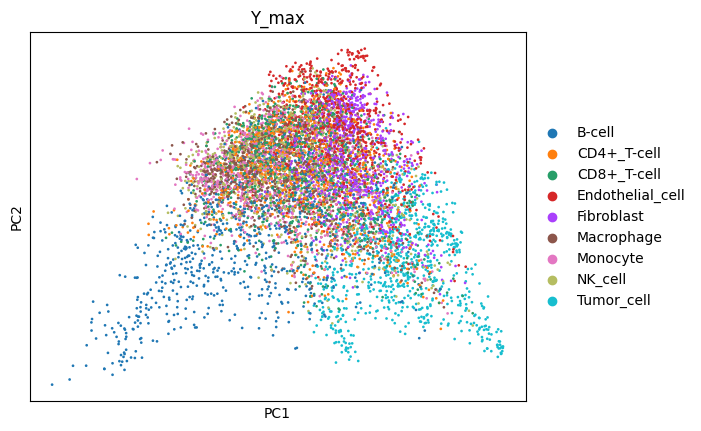

In [81]:
idx = np.where(adata.obs.cell_prop_type == "random" )[0]

sc.pl.pca(adata[idx], color='Y_max')